**Chapter 9 – Up and running with TensorFlow**

_This notebook contains all the sample code and solutions to the exercices in chapter 9._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tensorflow"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Creating and running a graph

In [2]:
import tensorflow as tf

In [3]:
tf.reset_default_graph()

x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [4]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
print(sess.run(f))
sess.close()

42


In [5]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

result

42

In [6]:
init = tf.global_variables_initializer()

with tf.Session():
    init.run()
    result = f.eval()

result

42

In [7]:
init = tf.global_variables_initializer()

sess = tf.InteractiveSession()
init.run()
result = f.eval()
sess.close()

result

42

# Managing graphs

In [8]:
tf.reset_default_graph()

x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [9]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

x2.graph is tf.get_default_graph()

False

In [10]:
x2.graph is graph

True

In [11]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())  # 10
    print(z.eval())  # 15

10
15


In [12]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

10
15


# Linear Regression

## Using the Normal Equation

In [13]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

downloading Cal. housing from http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz to /root/scikit_learn_data


In [14]:
tf.reset_default_graph()

X = tf.constant(housing_data_plus_bias, dtype=tf.float64, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float64, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    result = theta.eval()

print(result)

[[ -3.69419202e+01]
 [  4.36693293e-01]
 [  9.43577803e-03]
 [ -1.07322041e-01]
 [  6.45065694e-01]
 [ -3.97638942e-06]
 [ -3.78654265e-03]
 [ -4.21314378e-01]
 [ -4.34513755e-01]]


Compare with pure NumPy

In [15]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

[[ -3.69419202e+01]
 [  4.36693293e-01]
 [  9.43577803e-03]
 [ -1.07322041e-01]
 [  6.45065694e-01]
 [ -3.97638942e-06]
 [ -3.78654265e-03]
 [ -4.21314378e-01]
 [ -4.34513755e-01]]


Compare with Scikit-Learn

In [16]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[ -3.69419202e+01]
 [  4.36693293e-01]
 [  9.43577803e-03]
 [ -1.07322041e-01]
 [  6.45065694e-01]
 [ -3.97638942e-06]
 [ -3.78654265e-03]
 [ -4.21314378e-01]
 [ -4.34513755e-01]]


## Using Batch Gradient Descent

Gradient Descent requires scaling the feature vectors first. We could do this using TF, but let's just use Scikit-Learn for now.

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [18]:
print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[  1.00000000e+00   6.60969987e-17   5.50808322e-18   6.60969987e-17
  -1.06030602e-16  -1.10161664e-17   3.44255201e-18  -1.07958431e-15
  -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ..., -0.06612179 -0.06360587
  0.01359031]
0.111111111111
(20640, 9)


### Manually computing the gradients

In [19]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371
Best theta:
[[  2.06855226e+00]
 [  7.74078071e-01]
 [  1.31192386e-01]
 [ -1.17845096e-01]
 [  1.64778158e-01]
 [  7.44080753e-04]
 [ -3.91945168e-02]
 [ -8.61356616e-01]
 [ -8.23479712e-01]]


### Using autodiff
Same as above except for the `gradients = ...` line.

In [20]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = tf.gradients(mse, [theta])[0]
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371
Best theta:
[[  2.06855249e+00]
 [  7.74078071e-01]
 [  1.31192386e-01]
 [ -1.17845066e-01]
 [  1.64778143e-01]
 [  7.44078017e-04]
 [ -3.91945094e-02]
 [ -8.61356676e-01]
 [ -8.23479772e-01]]


### Using a `GradientDescentOptimizer`

In [21]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371
Best theta:
[[  2.06855249e+00]
 [  7.74078071e-01]
 [  1.31192386e-01]
 [ -1.17845066e-01]
 [  1.64778143e-01]
 [  7.44078017e-04]
 [ -3.91945094e-02]
 [ -8.61356676e-01]
 [ -8.23479772e-01]]


### Using a momentum optimizer

In [22]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.25)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [23]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Best theta:
[[  2.06855392e+00]
 [  7.94067979e-01]
 [  1.25333667e-01]
 [ -1.73580602e-01]
 [  2.18767926e-01]
 [ -1.64708309e-03]
 [ -3.91250364e-02]
 [ -8.85289013e-01]
 [ -8.50607991e-01]]


# Feeding data to the training algorithm

## Placeholder nodes

In [24]:
>>> tf.reset_default_graph()

>>> A = tf.placeholder(tf.float32, shape=(None, 3))
>>> B = A + 5
>>> with tf.Session() as sess:
...     B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
...     B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})
...
>>> print(B_val_1)
>>> print(B_val_2)

[[ 6.  7.  8.]]
[[  9.  10.  11.]
 [ 12.  13.  14.]]


## Mini-batch Gradient Descent

In [25]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [26]:
def fetch_batch(epoch, batch_index, batch_size):
    rnd.seed(epoch * n_batches + batch_index)
    indices = rnd.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()
    
print("Best theta:")
print(best_theta)

Best theta:
[[ 2.07001591]
 [ 0.82045609]
 [ 0.1173173 ]
 [-0.22739051]
 [ 0.31134021]
 [ 0.00353193]
 [-0.01126994]
 [-0.91643935]
 [-0.87950081]]


# Saving and restoring a model

In [27]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [28]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
            save_path = saver.save(sess, "/tmp/my_model.ckpt")
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, "my_model_final.ckpt")

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371
Best theta:
[[  2.06855249e+00]
 [  7.74078071e-01]
 [  1.31192386e-01]
 [ -1.17845066e-01]
 [  1.64778143e-01]
 [  7.44078017e-04]
 [ -3.91945094e-02]
 [ -8.61356676e-01]
 [ -8.23479772e-01]]


# Visualizing the graph
## inside Jupyter

In [29]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [30]:
show_graph(tf.get_default_graph())

## Using TensorBoard

In [31]:
tf.reset_default_graph()

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [32]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                summary_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

summary_writer.flush()
summary_writer.close()
print("Best theta:")
print(best_theta)

Best theta:
[[ 2.07001591]
 [ 0.82045609]
 [ 0.1173173 ]
 [-0.22739051]
 [ 0.31134021]
 [ 0.00353193]
 [-0.01126994]
 [-0.91643935]
 [-0.87950081]]


# Name scopes

In [33]:
tf.reset_default_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
with tf.name_scope('loss') as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [34]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                summary_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

summary_writer.flush()
summary_writer.close()
print("Best theta:")
print(best_theta)

Best theta:
[[ 2.07001591]
 [ 0.82045609]
 [ 0.1173173 ]
 [-0.22739051]
 [ 0.31134021]
 [ 0.00353193]
 [-0.01126994]
 [-0.91643935]
 [-0.87950081]]


In [35]:
print(error.op.name)

loss/sub


In [36]:
print(mse.op.name)

loss/mse


In [37]:
tf.reset_default_graph()

a1 = tf.Variable(0, name="a")      # name == "a"
a2 = tf.Variable(0, name="a")      # name == "a_1"

with tf.name_scope("param"):       # name == "param"
    a3 = tf.Variable(0, name="a")  # name == "param/a"

with tf.name_scope("param"):       # name == "param_1"
    a4 = tf.Variable(0, name="a")  # name == "param_1/a"

for node in (a1, a2, a3, a4):
    print(node.op.name)

a
a_1
param/a
param_1/a


# Modularity

An ugly flat code:

In [38]:
tf.reset_default_graph()

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")

w1 = tf.Variable(tf.random_normal((n_features, 1)), name="weights1")
w2 = tf.Variable(tf.random_normal((n_features, 1)), name="weights2")
b1 = tf.Variable(0.0, name="bias1")
b2 = tf.Variable(0.0, name="bias2")

linear1 = tf.add(tf.matmul(X, w1), b1, name="linear1")
linear2 = tf.add(tf.matmul(X, w2), b2, name="linear2")

relu1 = tf.maximum(linear1, 0, name="relu1")
relu2 = tf.maximum(linear1, 0, name="relu2")  # Oops, cut&paste error! Did you spot it?

output = tf.add_n([relu1, relu2], name="output")

Much better, using a function to build the ReLUs:

In [39]:
tf.reset_default_graph()

def relu(X):
    w_shape = int(X.get_shape()[1]), 1
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    linear = tf.add(tf.matmul(X, w), b, name="linear")
    return tf.maximum(linear, 0, name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")
summary_writer = tf.summary.FileWriter("logs/relu1", tf.get_default_graph())

Even better using name scopes:

In [40]:
tf.reset_default_graph()

def relu(X):
    with tf.name_scope("relu"):
        w_shape = int(X.get_shape()[1]), 1
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        linear = tf.add(tf.matmul(X, w), b, name="linear")
        return tf.maximum(linear, 0, name="max")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

summary_writer = tf.summary.FileWriter("logs/relu2", tf.get_default_graph())

In [41]:
summary_writer.close()

Sharing a `threshold` variable the classic way, by defining it outside of the `relu()` function then passing it as a parameter:

In [42]:
tf.reset_default_graph()

def relu(X, threshold):
    with tf.name_scope("relu"):
        w_shape = int(X.get_shape()[1]), 1
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        linear = tf.add(tf.matmul(X, w), b, name="linear")
        return tf.maximum(linear, threshold, name="max")

threshold = tf.Variable(0.0, name="threshold")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name="output")

In [43]:
tf.reset_default_graph()

def relu(X):
    with tf.name_scope("relu"):
        if not hasattr(relu, "threshold"):
            relu.threshold = tf.Variable(0.0, name="threshold")
        w_shape = int(X.get_shape()[1]), 1
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        linear = tf.add(tf.matmul(X, w), b, name="linear")
        return tf.maximum(linear, relu.threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [44]:
tf.reset_default_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
        w_shape = int(X.get_shape()[1]), 1
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        linear = tf.add(tf.matmul(X, w), b, name="linear")
        return tf.maximum(linear, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

summary_writer = tf.summary.FileWriter("logs/relu6", tf.get_default_graph())
summary_writer.close()

In [45]:
tf.reset_default_graph()

def relu(X):
    with tf.variable_scope("relu"):
        threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
        w_shape = int(X.get_shape()[1]), 1
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        linear = tf.add(tf.matmul(X, w), b, name="linear")
        return tf.maximum(linear, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("", default_name="") as scope:
    first_relu = relu(X)     # create the shared variable
    scope.reuse_variables()  # then reuse it
    relus = [first_relu] + [relu(X) for i in range(4)]
output = tf.add_n(relus, name="output")

summary_writer = tf.summary.FileWriter("logs/relu8", tf.get_default_graph())
summary_writer.close()

In [46]:
tf.reset_default_graph()

with tf.variable_scope("param"):
    x = tf.get_variable("x", shape=(), initializer=tf.constant_initializer(0.))
    #x = tf.Variable(0., name="x")
with tf.variable_scope("param", reuse=True):
    y = tf.get_variable("x")

with tf.variable_scope("", default_name="", reuse=True):
    z = tf.get_variable("param/x", shape=(), initializer=tf.constant_initializer(0.))

print(x is y)
print(x.op.name)
print(y.op.name)
print(z.op.name)

True
param/x
param/x
param/x


# Extra material

## Strings

In [47]:
tf.reset_default_graph()

text = np.array("Do you want some café?".split())
text_tensor = tf.constant(text)

with tf.Session() as sess:
    print(text_tensor.eval())

['Do' 'you' 'want' 'some' 'caf\xc3\xa9?']


## Distributed TensorFlow

In [48]:
server = tf.train.Server.create_local_server()

In [49]:
x = tf.constant(2) + tf.constant(3)
with tf.Session(server.target) as sess:
    print(sess.run(x))

5


In [50]:
server.target

'grpc://localhost:60347'

In [51]:
class Const(object):
    def __init__(self, value):
        self.value = value
    def evaluate(self, **variables):
        return self.value
    def __str__(self):
        return str(self.value)

class Var(object):
    def __init__(self, name):
        self.name = name
    def evaluate(self, **variables):
        return variables[self.name]
    def __str__(self):
        return self.name

class BinaryOperator(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b

class Add(BinaryOperator):
    def evaluate(self, **variables):
        return self.a.evaluate(**variables) + self.b.evaluate(**variables)
    def __str__(self):
        return "{} + {}".format(self.a, self.b)

class Mul(BinaryOperator):
    def evaluate(self, **variables):
        return self.a.evaluate(**variables) * self.b.evaluate(**variables)
    def __str__(self):
        return "({}) * ({})".format(self.a, self.b)

x = Var("x")
y = Var("y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2
print("f(x,y) =", f)
print("f(3,4) =", f.evaluate(x=3, y=4))

f(x,y) = ((x) * (x)) * (y) + y + 2
f(3,4) = 42


## Computing gradients
### Mathematical differentiation

In [52]:
df_dx = Mul(Const(2), Mul(Var("x"), Var("y")))  # df/dx = 2xy
df_dy = Add(Mul(Var("x"), Var("x")), Const(1))  # df/dy = x² + 1
print("df/dx(3,4) =", df_dx.evaluate(x=3, y=4))
print("df/dy(3,4) =", df_dy.evaluate(x=3, y=4))

df/dx(3,4) = 24
df/dy(3,4) = 10


### Numerical differentiation

In [53]:
def derivative(f, x, y, x_eps, y_eps):
    return (f.evaluate(x = x + x_eps, y = y + y_eps) - f.evaluate(x = x, y = y)) / (x_eps + y_eps)

df_dx_34 = derivative(f, x=3, y=4, x_eps=0.0001, y_eps=0)
df_dy_34 = derivative(f, x=3, y=4, x_eps=0, y_eps=0.0001)
print("df/dx(3,4) =", df_dx_34)
print("df/dy(3,4) =", df_dy_34)

df/dx(3,4) = 24.0004
df/dy(3,4) = 10.0


In [54]:
def f(x, y):
    return x**2*y + y + 2

def derivative(f, x, y, x_eps, y_eps):
    return (f(x + x_eps, y + y_eps) - f(x, y)) / (x_eps + y_eps)

df_dx = derivative(f, 3, 4, 0.00001, 0)
df_dy = derivative(f, 3, 4, 0, 0.00001)

In [55]:
print(df_dx)
print(df_dy)

24.0000399998
10.0000000003


### Symbolic differentiation

In [56]:
Const.derive = lambda self, var: Const(0)
Var.derive = lambda self, var: Const(1) if self.name==var else Const(0)
Add.derive = lambda self, var: Add(self.a.derive(var), self.b.derive(var))
Mul.derive = lambda self, var: Add(Mul(self.a, self.b.derive(var)), Mul(self.a.derive(var), self.b))

x = Var("x")
y = Var("y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2

df_dx = f.derive("x")  # 2xy
df_dy = f.derive("y")  # x² + 1
print("df/dx(3,4) =", df_dx.evaluate(x=3, y=4))
print("df/dy(3,4) =", df_dy.evaluate(x=3, y=4))

df/dx(3,4) = 24
df/dy(3,4) = 10


### Automatic differentiation (autodiff) – forward mode

In [57]:
class Const(object):
    def __init__(self, value):
        self.value = value
    def evaluate(self, derive, **variables):
        return self.value, 0
    def __str__(self):
        return str(self.value)

class Var(object):
    def __init__(self, name):
        self.name = name
    def evaluate(self, derive, **variables):
        return variables[self.name], (1 if derive == self.name else 0)
    def __str__(self):
        return self.name

class BinaryOperator(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b

class Add(BinaryOperator):
    def evaluate(self, derive, **variables):
        a, da = self.a.evaluate(derive, **variables)
        b, db = self.b.evaluate(derive, **variables)
        return a + b, da + db
    def __str__(self):
        return "{} + {}".format(self.a, self.b)

class Mul(BinaryOperator):
    def evaluate(self, derive, **variables):
        a, da = self.a.evaluate(derive, **variables)
        b, db = self.b.evaluate(derive, **variables)
        return a * b, a * db + da * b
    def __str__(self):
        return "({}) * ({})".format(self.a, self.b)

x = Var("x")
y = Var("y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2
f34, df_dx_34 = f.evaluate(x=3, y=4, derive="x")
f34, df_dy_34 = f.evaluate(x=3, y=4, derive="y")
print("f(3,4) =", f34)
print("df/dx(3,4) =", df_dx_34)
print("df/dy(3,4) =", df_dy_34)

f(3,4) = 42
df/dx(3,4) = 24
df/dy(3,4) = 10


### Autodiff – Reverse mode

In [58]:
class Const(object):
    def __init__(self, value):
        self.derivative = 0
        self.value = value
    def evaluate(self, **variables):
        return self.value
    def backpropagate(self, derivative):
        pass
    def __str__(self):
        return str(self.value)

class Var(object):
    def __init__(self, name):
        self.name = name
    def evaluate(self, **variables):
        self.derivative = 0
        self.value = variables[self.name]
        return self.value
    def backpropagate(self, derivative):
        self.derivative += derivative
    def __str__(self):
        return self.name

class BinaryOperator(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b

class Add(BinaryOperator):
    def evaluate(self, **variables):
        self.derivative = 0
        self.value = self.a.evaluate(**variables) + self.b.evaluate(**variables)
        return self.value
    def backpropagate(self, derivative):
        self.derivative += derivative
        self.a.backpropagate(derivative)
        self.b.backpropagate(derivative)
    def __str__(self):
        return "{} + {}".format(self.a, self.b)

class Mul(BinaryOperator):
    def evaluate(self, **variables):
        self.derivative = 0
        self.value = self.a.evaluate(**variables) * self.b.evaluate(**variables)
        return self.value
    def backpropagate(self, derivative):
        self.derivative += derivative
        self.a.backpropagate(derivative * self.b.value)
        self.b.backpropagate(derivative * self.a.value)
    def __str__(self):
        return "({}) * ({})".format(self.a, self.b)

In [59]:
x = Var("x")
y = Var("y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2
f34 = f.evaluate(x=3, y=4)
f.backpropagate(1)
print("f(3,4) =", f34)
print("df/dx(3,4) =", x.derivative)
print("df/dy(3,4) =", y.derivative)

f(3,4) = 42
df/dx(3,4) = 24
df/dy(3,4) = 10


### Autodiff – reverse mode (using TensorFlow)

In [60]:
tf.reset_default_graph()

x = tf.Variable(3., name="x")
y = tf.Variable(4., name="x")
f = x*x*y + y + 2

gradients = tf.gradients(f, [x, y])

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    f_val, gradients_val = sess.run([f, gradients])

f_val, gradients_val

(42.0, [24.0, 10.0])

# Exercise solutions

### 1. What are the main benefits of creating a computation graph rather than directly executing the computations? What are the main drawbacks?

   Benefits: Automated tools can parallelize the workflow across available
   processing units, tools like Tensorboard can visualize the workflow.

   Drawbacks: Harder to reason about, actual calculations are less transparent.
   (E.g., tfdbg is the best way to debug a broken calculation.)


### 2. Is the statement `aval=a.eval(session=sess)` equivalent to `aval=sess.run(a)`?

Yes

### 3. Is the statement `aval, bval=a.eval(session=sess), b.eval(session=sess)`  equivalent to `aval, bval=sess.run([a, b])`?

   No. The first statement results in two executions of the computation graph,
   the second only one. For the first statement, the first evaluation only
   executes nodes necessary to compute `a`, the second only those needed for
   `b`. If execution of the graph for `a` changes parameter values, the results
   for `b` could be different. If nodes necessary for `b` change the calculation
   for `a`, the value of `a` could be different.


### 4. Can you run two graphs in the same session?

   [No](https://www.tensorflow.org/api_docs/python/tf/Session#__init__): "If you are using more than one graph (created with tf.Graph() in the
   same process, you will have to use different sessions for each graph, but
   each graph can be used in multiple sessions."


### 5. If you create a graph g containing a variable w, then start two threads an open a session in each thread, both using the same graph g, will each session have its own copy of the variable w or will it be shared?

The value is shared. Test code, where the `report_thread` checks that it sees the modification made by the `mod_thread`:

In [61]:
import tensorflow as tf
from tensorflow.python import debug as tf_debug

import threading, time

theta = tf.Variable(0)
mod_op = theta.assign(1)

init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

def mod_thread():
    time.sleep(1)
    print('modification thread initial value:', sess.run([theta]))
    print(sess.run([mod_op]))
    print('following modification:', sess.run([theta]))

def report_thread():
    for i in range(3):
        time.sleep(0.5)
        print(sess.run([theta]))

threads = [threading.Thread(target=mod_thread),
           threading.Thread(target=report_thread)]

for thread in threads:
    thread.start()

for thread in threads:
    thread.join()

[0]
modification thread initial value: [0][1]

[1]
following modification: [1]
[1]


### 6.  When is a variable initialized? When is it destroyed?
Initialized when you run the relevant initializer op in a session. Presumably
destroyed when the containing graph is destroyed?

### 7. What is the difference between a placeholder and a variable?
A variable contains a value. A placeholder receives a value at runtime, e.g.
via the feed_dict argument to Session.run.

### 8. What happens when you run the graph to evaluate an operation that depends on a placeholder but you don’t feed its value? What happens if the operation does not depend on the placeholder?

For the first question, you get an **`InvalidArgumentError: You must feed a value for placeholder tensor`:**

In [62]:
x = tf.placeholder(tf.float32)
sess = tf.Session()
try:
    sess.run([x])
except tf.errors.InvalidArgumentError, e:
    print(e.message)

You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


For the second question, the calculation goes through without problems:

In [63]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, name='x')
y = tf.Variable(0, name='y')
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run([init])
print('This runs without problems:', sess.run([y]))
tf.get_default_graph().get_tensor_by_name("x:0") # Verify that x is in the graph

This runs without problems: [0]


<tf.Tensor 'x:0' shape=<unknown> dtype=float32>

### 9. When you run a graph, can you feed the output value of any operation, or just the value of placeholders?

Any. E.g.

In [64]:
x = tf.Variable(30)
op = x + 5
init = tf.global_variables_initializer()
sess.run([init])
print(sess.run([op]))
sess.run([op], feed_dict={op: 40})

[35]


[array(40, dtype=int32)]

### 10. How can you set a variable to any value you want (during the execution phase)?

    You can use `Variable.assign(x)`, as long as `x` is of a compatible type.

### 11. How many times does reverse-mode autodiff need to traverse the graph in order to compute the gradients of the cost function with regards to 10 variables? What about forward-mode autodiff? And symbolic differentiation? 
    
Reverse-mode: Twice; once forward and once backward for the single output variable.

Forward mode: Roughly ten times; once for each input variable, but only the parts of the graph to which that variable pertains.

Symbolic: Twice; once for the symbolic calculation of the derivatives, then once for the numeric calculations.

### 12. Implement Logistic Regression with Mini-batch Gradient Descent using TensorFlow. 
Train it and evaluate it on the moons dataset (introduced in
Chapter 5). Try adding all the bells and whistles:

* Define the graph within a logistic_regression() function that can be
  reused easily.
* Save checkpoints using a Saver at regular intervals during training, and
  save the final model at the end of training.
* Restore the last checkpoint upon startup if training was interrupted.
* Define the graph using nice scopes so the graph looks good in TensorBoard.
* Add summaries to visualize the learning curves in TensorBoard.
* Try tweaking some hyperparameters such as the learning rate or the
  mini-batch size and look at the shape of the learning curve.

Most of the machinery for this is in the "Mini-Batch Gradient Descent" section above. Copying from there, and [this example](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/2_BasicModels/logistic_regression.py):

In [81]:
import time, tempfile, os, glob, collections, re

tempdir = tempfile.mkdtemp()
logdir = os.path.join(tempdir, 'lr', 'graph')
chkpath = os.path.join(tempdir, 'chkpt-%s' % time.time())

LRTensors = collections.namedtuple(
    'LRTensors', 'init W b pred cost training_op summaries writer saver')

Parameters = collections.namedtuple('Parameters', 'W b')

def logistic_regression(inputs, outputs, learning_rate=0.01):
    """Generate a TF graph for training a logistic regression model.
    
    Training occurs by optimizing the softmax probability of the observed events
    in the training data, assuming the observations are IID.
    
    `inputs` and `outputs` are placeholder tensors for batched training data.
    `outputs` values should be one-hot encoded over the possible events
    
    Returns tuple containing tensors for initializer, weights, bias, the predicted 
    logistic probabilities for the events, the cost, and the training, summary and 
    saving operations.
    
    """
    with tf.variable_scope('lr'):
        n, m = int(inputs.shape[1]), int(outputs.shape[1])
        W = tf.Variable(tf.random_uniform([n, m], -1.0, 1.0, seed=42), 
                        name="parameters/weights")
        b = tf.Variable([0]*n, dtype=tf.float32, name='parameters/bias')
        parameters = Parameters(W, b)
        pred = tf.nn.softmax(tf.matmul(inputs, W) + b, name='outputs/probs')
        # Extract the predicted log probability of the observed event for each 
        # training case. Each row of outputs contains '1' in observed column
        # and '0' in all other columns, so summing the rows of 
        # outputs*tf.log(pred) gives a single nonzero summand for each.
        probs = -tf.reduce_sum(outputs*tf.log(pred),
                               reduction_indices=1, name='outputs/logprobs')
        # The total probability of the observations, under the IID assumption.
        cost = tf.reduce_mean(probs, name='outputs/cost')
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                              momentum=0.25)
        training_op = optimizer.minimize(cost)
        init = tf.global_variables_initializer()
        saver = tf.train.Saver(parameters._asdict())
        cost_summary = tf.summary.scalar('cost', cost)
        summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
        summaries = tf.summary.merge_all()
        return LRTensors(init, W, b, pred, cost, training_op, summaries, 
                         summary_writer, saver)

In [66]:
from sklearn.datasets import make_moons as mm
position, is_moon = mm(1000000, random_state=42)
moon_1hot = np.zeros((position.shape[0], len(set(is_moon))))
for rowidx, moonp in enumerate(is_moon):  # Should be some np magic for this.
    moon_1hot[rowidx, moonp] = 1

In [79]:
from sklearn.model_selection import train_test_split

train_positions, test_positions, train_moon, test_moon = (
    train_test_split(position, moon_1hot, test_size=0.20, random_state=42))

In [82]:
tf.reset_default_graph()

def fetch_batch(epoch, batch_index, batch_size):
    rnd.seed(epoch * n_batches + batch_index)
    indices = rnd.randint(train_positions.shape[0], size=batch_size)
    X_batch = train_positions[indices]
    y_batch = train_moon[indices]
    return X_batch, y_batch

batch_size = 100
n_batches = int(np.ceil(m / batch_size))

sess = tf.Session()

X = tf.placeholder(tf.float32, shape=(None, position.shape[1]),
                   name='X_batch')
y = tf.placeholder(tf.float32, shape=(None, moon_1hot.shape[1]),
                   name='Y_batch')

tensors = logistic_regression(X, y, learning_rate=0.1)

sess.run(tensors.init)

# Check whether there's a checkpoint to restore from
checkpoints = glob.glob(chkpath + '-*')
if checkpoints:  # Restore from last checkpoint
    # Remove the suffix from the last checkpoint
    last_chk = re.sub(r'\.[^.]+$', '', max(checkpoints))
    tensors.saver.restore(sess, last_chk)

epoch = 0
best_test_cost = np.inf

while True:
    for batch_index in range(n_batches):
        X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
    _, ccost = sess.run([tensors.training_op, tensors.cost], 
                        feed_dict={X: X_batch, y: y_batch})
    if epoch % 1000 == 0:
        [test_cost, test_summaries] = sess.run(
            [tensors.cost, tensors.summaries], 
            feed_dict={X: test_positions, y: test_moon})
        print('train cost: %.5f' % ccost, 'test cost:', test_cost)
        tensors.saver.save(sess, chkpath, global_step=epoch)
        tensors.writer.add_summary(test_summaries, epoch)
        tensors.writer.flush()  # Ensure tensorboard can read summary
        if test_cost >= best_test_cost:  # Early stopping rule
            break
        best_test_cost = test_cost
    epoch += 1

parameters = Parameters(*sess.run([tensors.W, tensors.b]))
    
print("Best parameters:")
print(parameters)

train cost: 0.86902 test cost: 0.812872
train cost: 0.24521 test cost: 0.243336
train cost: 0.24344 test cost: 0.240622
train cost: 0.24329 test cost: 0.240232
train cost: 0.24327 test cost: 0.240139
train cost: 0.24327 test cost: 0.240106
train cost: 0.24327 test cost: 0.240097
train cost: 0.24327 test cost: 0.240094
train cost: 0.24327 test cost: 0.240093
train cost: 0.24327 test cost: 0.240093
train cost: 0.24327 test cost: 0.240093
Best parameters:
Parameters(W=array([[ 0.09289816,  1.16656089],
       [ 3.69480968, -2.59261751]], dtype=float32), b=array([-0.69547945,  0.69548136], dtype=float32))


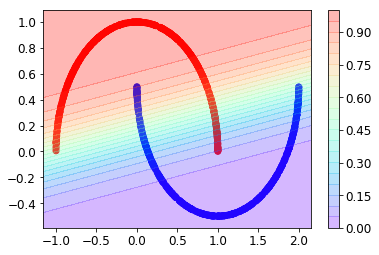

In [69]:
from matplotlib import pyplot as plt
plt.scatter(*zip(*position[:1000]), c=['rb'[m] for m in is_moon[:1000]])

xbounds, ybounds = plt.xlim(), plt.ylim()
x, y = [np.arange(*b, step=0.01) for b in [xbounds, ybounds]]
xy = [(x0, y0) for y0 in y for x0 in x]
[probs] = sess.run([tensors.pred], feed_dict={X: xy})
# x, y reversed because first index to probs is rows, second is columns.
probs = (probs[:, 0].reshape((len(y), len(x))))
xv, yv = np.meshgrid(x, y)
plt.contourf(xv, yv, probs, 20, cmap=plt.cm.rainbow, alpha=0.3)
plt.colorbar();

In [70]:
show_graph(tf.get_default_graph())

In [71]:
# Open <jupyter-domain>:8000 in your browser to view the tensorboard graph
os.system('tensorboard --logdir="%s" --port=8000' % logdir)

2